In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
import graphviz
import warnings
warnings.filterwarnings('ignore')

/Users/jp/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('../data/usedCarListingCleaned.csv')
del df['Unnamed: 0']
df=df[df.title != 'Lemon'] # get rid of one record of Lemon car 
df['year'] = df['year'].astype(object)
print(df.shape)
df.head()

(9982, 22)


,year,make,model,sub_model,city,state,mileage,price,exterior_color,interior_color,...,engine,transmission,drive_type,fuel_type,popular_feature,cpo,num_accident,usage_type,title,num_owner
0,2017,BMW,['X3'],xDrive28i AWD,Marietta,GA,77549,16709,Mineral White Metallic,Mocha,...,2.0L Inline-4 Gas Turbocharged,Automatic,AWD,Gas,[],False,0,Personal or Rental Use,Clean,1
1,2018,Ford,['F-150'],XLT SuperCrew 5.5' Box 4WD,Deland,FL,11624,26985,Shadow Black,Medium Earth Gray,...,2.7L V-6 Gas Turbocharged,Automatic,4WD,Gas,"['Cruise Control', 'Bluetooth', 'Backup Camera']",False,0,Personal or Rental Use,Clean,1
2,2018,GMC,"['Savana', 'Cargo', 'Van']",2500 Short Wheelbase,Pelham,AL,23997,19990,Summit White,Unknown,...,6.0L V-8 Gas,Automatic,RWD,Gas,"['Cruise Control', 'Backup Camera']",False,0,Personal or Rental Use,Clean,1
3,2017,Nissan,['Rogue'],SV AWD,Palmetto Bay,FL,78116,9997,Magnetic Black,Charcoal,...,2.5L Inline-4 Gas,Automatic,AWD,Gas,"['Front Heated Seats', 'Cruise Control', 'Back...",False,2,Fleet or Mixed Use,Clean,1
4,2017,Toyota,['RAV4'],XLE AWD,Great Falls,MT,189335,13495,Super White,Black,...,2.5L Inline-4 Gas,Automatic,AWD,Gas,[],False,0,Personal or Rental Use,Clean,1


In [3]:
## Check levels for different categorical variables

In [4]:
cat_cols = ['year', 'make', 'model', 'sub_model', 'city', 'state', 'exterior_color', 'interior_color',
           'engine', 'transmission', 'drive_type', 'fuel_type', 'cpo', 'usage_type', 'title']
num_cols = ['mileage', 'mpg_city', 'mpg_hwy', 'num_accident', 'num_owner']
res_y = 'price'

In [5]:
for column in cat_cols:
    print('The number of unique level for {} is {}'.format(column, len(df[column].unique())) )

The number of unique level for year is 24
The number of unique level for make is 53
The number of unique level for model is 498
The number of unique level for sub_model is 1826
The number of unique level for city is 1564
The number of unique level for state is 50
The number of unique level for exterior_color is 1049
The number of unique level for interior_color is 558
The number of unique level for engine is 179
The number of unique level for transmission is 2
The number of unique level for drive_type is 4
The number of unique level for fuel_type is 7
The number of unique level for cpo is 2
The number of unique level for usage_type is 2
The number of unique level for title is 4


#### Since we only have 9982 data records, and after the train-test-split, we may only have very limited data for training. Therefore, it's a good idea to drop catagorical variables that have too many levels.

Since from last notebook, we noticed that for state variable, it does not seem to impact the price since the price distribution is very similar when we compare CA and non-CA, CA and TX. Therefore, I will also drop state variable in order to reduce the number of columns after onehot encoding.

I will drop categorical variables including state, model, sub_model, city, exterior_color, interior_color, engine

In [6]:
left_cat_cols=['year', 'make',  'transmission', 'drive_type', 'fuel_type', 'cpo', 'usage_type', 'title']

## One hot encoding and Train test split

The reason for doing onehot encoding before train test split is that: no matter how I do the split, there will always be level mismatch in train and test data, which will give different number of predictors in train and test datasets.

To overcome this, I decided to do onehot encoding before the train test split.

Do log transformation for price

In [7]:
final_cols = left_cat_cols + num_cols
y = np.log(df[res_y].values)

In [8]:
%%time
X = pd.get_dummies(df[final_cols], drop_first=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=10)
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

(8983, 95) (999, 95) (8983,) (999,)
CPU times: user 29.7 ms, sys: 3.83 ms, total: 33.6 ms
Wall time: 34.9 ms


## Standardization for numeric features

In [9]:
scaled_num_cols = ['scaled_'+col for col in num_cols]
num_scaler = StandardScaler().fit(X_tr[num_cols])

In [10]:
%%time
X_tr_num_scaled = pd.DataFrame(num_scaler.transform(X_tr[num_cols]), 
                                  index = X_tr.index, columns = scaled_num_cols)

CPU times: user 2.58 ms, sys: 997 µs, total: 3.57 ms
Wall time: 2.62 ms


In [11]:
%%time
X_te_num_scaled = pd.DataFrame(num_scaler.transform(X_te[num_cols]), index = X_te.index, columns = scaled_num_cols)

CPU times: user 2.11 ms, sys: 157 µs, total: 2.27 ms
Wall time: 2.23 ms


In [12]:
print(X_tr_num_scaled.shape, X_te_num_scaled.shape)

(8983, 5) (999, 5)


## Combine onehoted categorical columns and standardized numerical columns for both train and test data

In [13]:
X_tr_final = pd.concat([X_tr_num_scaled, X_tr.drop(num_cols, axis=1)], axis=1)
X_te_final = pd.concat([X_te_num_scaled, X_te.drop(num_cols, axis=1)], axis=1)
print(X_tr_final.shape, X_te_final.shape)

(8983, 95) (999, 95)


## Check the train test data in terms of distribution

I found that the distributions of response variable 'price' and one of the indicator variable 'mileage' in train and test data are very similar, which is good.

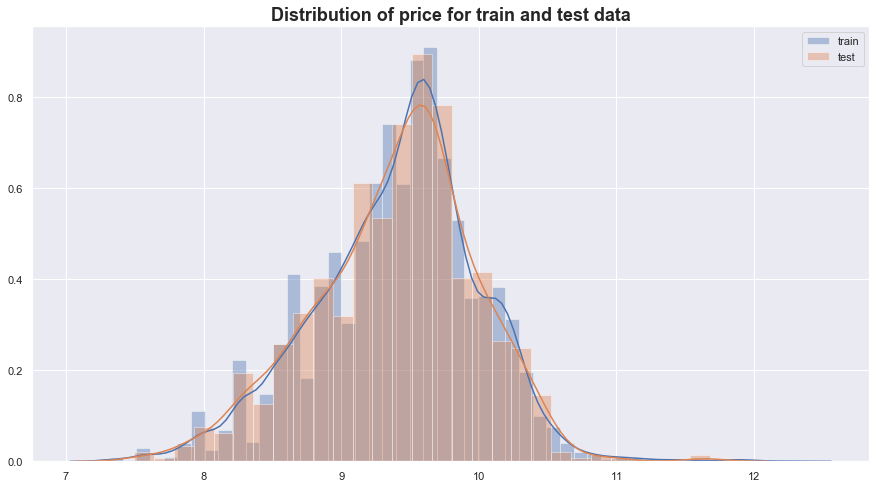

In [14]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.distplot(y_tr,hist_kws={"label":'train'})
sns.distplot(y_te,hist_kws={"label":'test'})
plt.title('Distribution of price for train and test data',fontsize=18,fontweight="bold")
plt.legend()
plt.show()

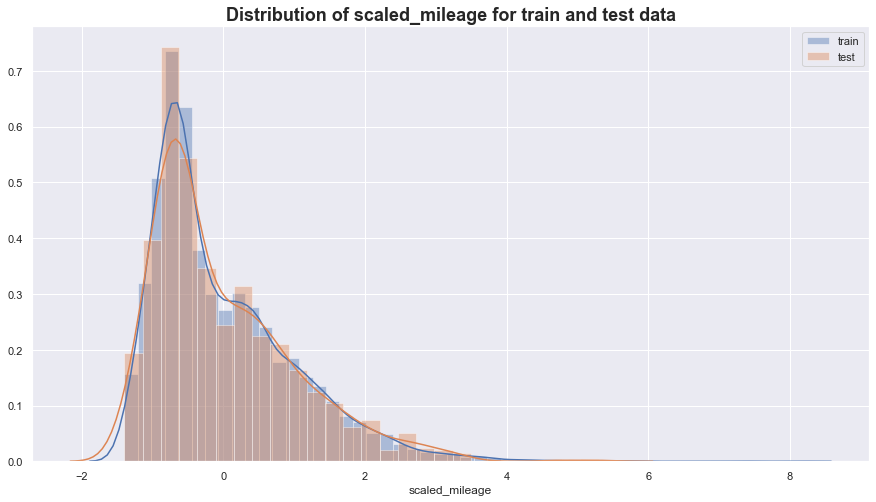

In [15]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.distplot(X_tr_final.scaled_mileage,hist_kws={"label":'train'})
sns.distplot(X_te_final.scaled_mileage,hist_kws={"label":'test'})
plt.title('Distribution of scaled_mileage for train and test data',fontsize=18,fontweight="bold")
plt.legend()
plt.show()

# xgboost model

In [24]:
# check the shape
X_tr_final.shape, y_tr.shape

((8983, 95), (8983,))

In [17]:
### train validataion split
X_tr, X_val, y_train, y_val = train_test_split(X_tr_final, y_tr, test_size=0.2, random_state=1024)
print('Training data dimensions are {} for X_tr, {} for y_train'.format(X_tr.shape, y_train.shape))
print('Validation data dimensions are {} for X_val, {} for y_val'.format(X_val.shape, y_val.shape))

Training data dimensions are (7186, 95) for X_tr, (7186,) for y_train
Validation data dimensions are (1797, 95) for X_val, (1797,) for y_val


In [18]:
## Create DMatrix for xgboost model
train_dmatrix = xgb.DMatrix(X_tr, label=y_train)
val_dmatrix = xgb.DMatrix(X_val, label=y_val)
eval_setting = [(train_dmatrix, 'train'), (val_dmatrix, 'eval')]

In [19]:
%%time
xgb_params = {'colsample_bytree': 0.4,
             'eta': 0.1,
             'gamma': 2,
             'max_depth': 4,
             'min_child_weight': 100,
             'objective': 'reg:linear',
             'seed': 1024,
             'subsample': 1,
             'eval_metric': 'rmse'
             }
model = xgb.train(params=xgb_params,
                 dtrain=train_dmatrix,
                 num_boost_round=500,
                 evals=eval_setting,
                 early_stopping_rounds=50,
                 verbose_eval=100
                 )
best_iteration = model.best_iteration
best_score = model.best_score
print('Model best score is {}, best iteration is {}'.format(best_score, best_iteration))

[21:22:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:8.04394	eval-rmse:8.02474
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.253193	eval-rmse:0.26849
[200]	train-rmse:0.246514	eval-rmse:0.26323
[300]	train-rmse:0.244945	eval-rmse:0.262035
[400]	train-rmse:0.244026	eval-rmse:0.26107
[499]	train-rmse:0.242838	eval-rmse:0.260026
Model best score is 0.260026, best iteration is 490
CPU times: user 9.27 s, sys: 30.7 ms, total: 9.3 s
Wall time: 9.33 s


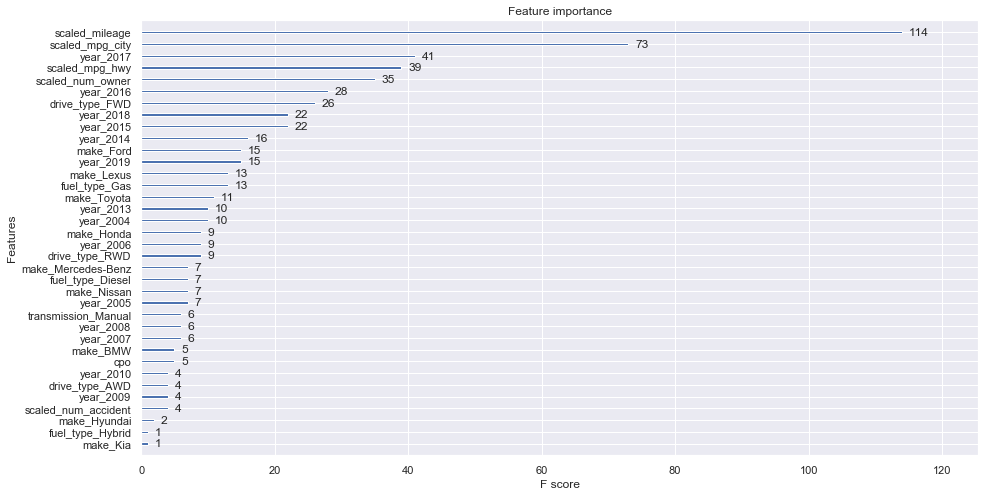

In [20]:
xgb.plot_importance(model)


The most important features include mileage, mpg (mpg_city, hwy) and number of previous owners, and model year.

From our previous EDA session, we also found taht mileage and mpg seem to matter when determining the resell price. And model year is also an important factor.

## Making prediction on test data

In [21]:
test_dmatrix=xgb.DMatrix(X_te_final)
y_pred = pd.Series(model.predict(test_dmatrix))
pred_price = y_pred.apply(np.exp).clip(lower=0.)

In [22]:
mae = np.mean(abs(pred_price-np.exp(y_te)))
print('The MAE for test data is about ${}'.format(mae))

The MAE for test data is about $2577.244494983264


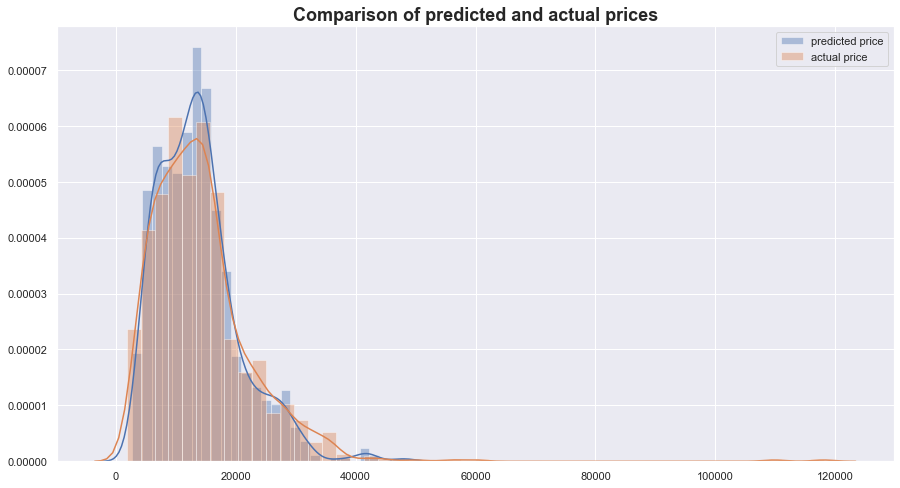

In [23]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.distplot(pred_price,hist_kws={"label":'predicted price'})
sns.distplot(np.exp(y_te),hist_kws={"label":'actual price'})
plt.title('Comparison of predicted and actual prices',fontsize=18,fontweight="bold")
plt.legend()
plt.show()